# import libraries

In [1]:
import numpy as np
from sklearn.neural_network import MLPRegressor
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
#from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from scipy.stats import shapiro
from scipy.stats import pearsonr
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency
from sklearn.pipeline import make_pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import Ridge
from scipy import special

# Load dataset


In [2]:
df = pd.read_csv(r'C:\Users\Adler_Sky\Desktop\immo_data.csv')


In [15]:
import time
Start = time.perf_counter()

######  در این قسمت داده ها فراخوانی شده اند

# Section 1: Remove missing values,...

In [16]:
df1 = df.drop(labels=['typeOfFlat', 'streetPlain', 'street', 'petsAllowed', 'interiorQual',
        'petsAllowed', 'condition', 'geo_krs', 'houseNumber', 'yearConstructedRange', 'geo_bln',
        'firingTypes', 'noParkSpaces', 'scoutId', 'yearConstructed', 'totalRent', 'telekomUploadSpeed',
        'telekomHybridUploadSpeed', 'telekomTvOffer', 'telekomTvOffer',
        'thermalChar','floor', 'numberOfFloors', 'regio2', 'regio3',
        'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass',
        'lastRefurbish', 'electricityBasePrice', 'electricityKwhPrice', 'date'] ,axis=1)
df1 = df1.dropna(axis=0, how='any')
df1 = df1.drop_duplicates()

###### در قسمت بالا ابتدا لیستی از متغیرهای با میزان زیاد میسینگ ولیو را حذف کردیم. سپس به حذف میسینگ ولیو و تکراری ها پرداختیم

### سپس با استفاده تعریف توزیع نرمال و سنجش پراکندگی بیش از 3 برابر از میانگین، رگوردهایی که مقدار آن ها در پارامترهای انتخاب شده بیش از 3 انحراف معیار از میانگین فاصله دارند به عنوان داده پرت شناسایی شدند 

In [17]:
temp1 = [np.abs(df1[['serviceCharge']]
-df1[['serviceCharge']].mean()) <=
    (3*df1[['serviceCharge']].std())]

NoOutlierrows = np.any(np.array(temp1[0]), axis=1)
df2 = df1.iloc[NoOutlierrows,:]

In [18]:
##### calculate time for section 4
Finish = time.perf_counter()


In [19]:
print(Finish-Start)

28.009487700000022


# Section 2: Overal Information

### plot count of rooms by neighbourhood group

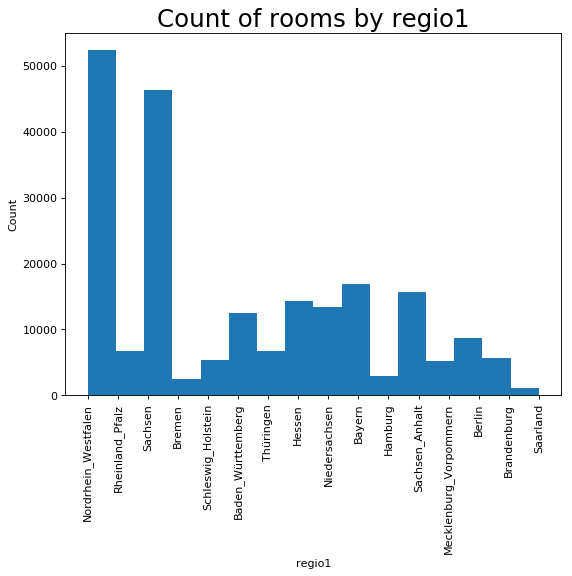

In [20]:
x_var = 'regio1'
vals = [df2[x_var].values.tolist()]

plt.figure(figsize=(8,6), dpi= 80)
plt.hist(vals, df2[x_var].unique().__len__(), stacked=False, density=False)
plt.title(f"Count of rooms by regio1", fontsize=22)
plt.xlabel(x_var)
plt.ylabel("Count")
plt.xticks(rotation='vertical')
plt.show()

### در قسمت بالا فراوانی تعداد آگهی ها در هر منطقه جغرافیایی  نمایش داده شده است.


###### همانطور که در شکل بالا مشخص است، پراکندگی فراوانی آگهی در مناطق مختلف بالا است. در میان تمامی مناطق، و منطقه زیر فراوانی بسیار بالایی دارند:
    1) Nordrhein_westalen
    2) Sachsen

###### در مقابل، مناطقی مانند 
bermen 
و
saarland فراوانی تعداد آگهی کمتری دارند

### plot relationship between region and price

In [28]:
df_raw = df2[['serviceCharge', 'regio1']].groupby('regio1').apply(lambda x: np.mean(x))
#sns.lmplot(x=pd.factorize(df2['regio1'])[0], y="serviceCharge", data=df2)


C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [31]:
print(df_raw)

                        serviceCharge
regio1                               
Baden_Württemberg          177.537581
Bayern                     170.230883
Berlin                     195.782026
Brandenburg                135.130756
Bremen                     151.484099
Hamburg                    198.756956
Hessen                     197.758663
Mecklenburg_Vorpommern     119.713191
Niedersachsen              144.641637
Nordrhein_Westfalen        155.707437
Rheinland_Pfalz            155.173850
Saarland                   158.566849
Sachsen                    134.193050
Sachsen_Anhalt             114.835066
Schleswig_Holstein         138.760762
Thüringen                  123.692952


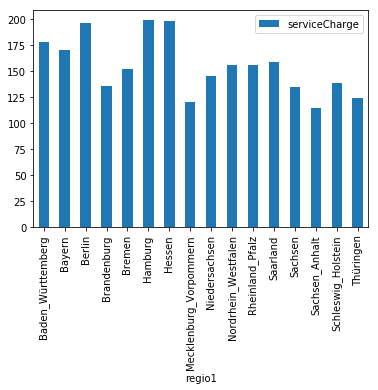

In [45]:
df_raw.plot.bar()


###### آنطور که مشخص است، تغییرات قیمت در بین مناطق جغرافیایی چندان متفاوت نیست

# Section 3: Forecast charge

### Forecast charge using multiple linear regression

In [20]:
Start3 = time.perf_counter()

df2['regio1'] = pd.factorize(df2['regio1'])[0] 
df2['heatingType'] = pd.factorize(df2['heatingType'])[0]

df2['newlyConst'] = pd.factorize(df2['newlyConst'])[0] 
df2['balcony'] = pd.factorize(df2['balcony'])[0]

df2['hasKitchen'] = pd.factorize(df2['hasKitchen'])[0] 
df2['cellar'] = pd.factorize(df2['cellar'])[0]

df2['lift'] = pd.factorize(df2['lift'])[0] 
df2['garden'] = pd.factorize(df2['garden'])[0]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

In [36]:
print(df2)

        regio1  serviceCharge  heatingType  newlyConst  balcony  picturecount  \
0            0         245.00            0           0        0             6   
1            1         134.00            1           0        1             8   
2            2         255.00            2           1        1             8   
3            2          58.15            3           0        1             9   
4            3         138.00            1           0        1            19   
...        ...            ...          ...         ...      ...           ...   
268845       9          90.00            9           0        1             0   
268846       7         220.00            4           0        1            12   
268847       7         220.00            0           0        1            21   
268848       0         175.00            9           1        1            16   
268849       7         315.00            0           0        1             9   

        pricetrend  hasKitc

### در خطوط بالا متغیرهای متنی به حالت عددی کدگذاری شده اند

In [21]:
Y = df2['picturecount']
X = df2

In [38]:

from sklearn.linear_model import LinearRegression
MLR = LinearRegression().fit(X, Y)


In [39]:
print(MLR.coef_)

[-3.58299556e-17 -9.82070328e-16 -2.01939630e-16  3.77596978e-15
 -5.35178212e-15  1.00000000e+00 -1.57810456e-17 -4.00217887e-16
 -1.76045117e-16  9.90776655e-17  4.58396286e-17  3.40663524e-17
 -4.35156213e-16 -1.89464487e-17  5.22226387e-18 -1.55794856e-17
 -7.33018136e-17  4.68176220e-17]


In [40]:
print(X.columns)

Index(['regio1', 'serviceCharge', 'heatingType', 'newlyConst', 'balcony',
       'picturecount', 'pricetrend', 'hasKitchen', 'cellar', 'baseRent',
       'livingSpace', 'lift', 'baseRentRange', 'geo_plz', 'noRooms',
       'noRoomsRange', 'garden', 'livingSpaceRange'],
      dtype='object')


###### با توجه به نتیجه مدل رگرسیونی آموزش دیده و مقادیر ضرایب آن مشاهده می شود که 
picturecount

بیشترین اهمیت را در مدل رگرسیونی داشته است
    

In [41]:
Finish3 = time.perf_counter()
print(Finish3-Start3)

12.359803499999543


# Section 4: using multiprocessing in preprocessing
    

In [26]:
from multiprocessing import Process


In [28]:
def do_preprocess():
    df1 = df.drop(labels=['typeOfFlat', 'streetPlain', 'street', 'petsAllowed', 'interiorQual',
        'petsAllowed', 'condition', 'geo_krs', 'houseNumber', 'yearConstructedRange', 'geo_bln',
        'firingTypes', 'noParkSpaces', 'scoutId', 'yearConstructed', 'totalRent', 'telekomUploadSpeed',
        'telekomHybridUploadSpeed', 'telekomTvOffer', 'telekomTvOffer',
        'thermalChar','floor', 'numberOfFloors', 'regio2', 'regio3',
        'description', 'facilities', 'heatingCosts', 'energyEfficiencyClass',
        'lastRefurbish', 'electricityBasePrice', 'electricityKwhPrice', 'date'] ,axis=1)
    df1 = df1.dropna(axis=0, how='any')
    df1 = df1.drop_duplicates()

    temp1 = [np.abs(df1[['serviceCharge']]
   -df1[['serviceCharge']].mean()) <=
    (3*df1[['serviceCharge']].std())]

    NoOutlierrows = np.any(np.array(temp1[0]), axis=1)
    df2 = df1.iloc[NoOutlierrows,:]
    
Start1 = time.perf_counter()    
# using multiprocessing for preprocessing
pl = Process(target=do_preprocess)


Finish1 = time.perf_counter()

In [29]:
print(Finish1-Start1)

6.570000005012844e-05


###### همانطور که در یخش 1 محاسبه شد، مدت زمان انجام پیش پردازش در حالت عادی 

7.478757599999881

بوده است. اما با استفاده از

multiprocessing

این زمان به

6.570000005012844e-05

کاهش یافته است

# Section 5: using dask in preprocessing


In [30]:
 from dask import delayed

In [31]:
Start2 = time.perf_counter()    
# using multiprocessing for preprocessing
p2 = delayed(do_preprocess)

Finish2 = time.perf_counter()

In [32]:
print(Finish2-Start2)

0.00018379999892204069


###### همانطور که مشخص است با استفاده از

dask

زمان پیش پردازش به 

0.00018379999892204069

کاهش یافته است

# Section 6: using dask in modeling

In [34]:
def modeling():
    df2['regio1'] = pd.factorize(df2['regio1'])[0] 
    df2['heatingType'] = pd.factorize(df2['heatingType'])[0]

    df2['newlyConst'] = pd.factorize(df2['newlyConst'])[0] 
    df2['balcony'] = pd.factorize(df2['balcony'])[0]

    df2['hasKitchen'] = pd.factorize(df2['hasKitchen'])[0] 
    df2['cellar'] = pd.factorize(df2['cellar'])[0]

    df2['lift'] = pd.factorize(df2['lift'])[0] 
    df2['garden'] = pd.factorize(df2['garden'])[0]
    
    Y = df2['serviceCharge']
    X = df2
    from sklearn.linear_model import LinearRegression
    MLR = LinearRegression().fit(X, Y)

    
    

    
Start4 = time.perf_counter()    
# using multiprocessing for modeling
p3 = delayed(modeling)


Finish4 = time.perf_counter()
print(Finish4-Start4)

0.00023830000282032415


###### در قسمت 3 مشاهده شد که مدلسازی در حالت عادی 

12.359803499999543

ثانیه زمان برد. 
اما در این بخش مشاهده شد که استفاده از 

dask

زمان اجرای مدلسازی را به

0.00023830000282032415

کاهش داد.

# Section 7: using feature enginearing for improve modeliing

###### در این قسمت هدف بهبود کارایی مدل یادگیری با استفاده از مهندسی  ویژگی است. برای این منظور، ابتدا ما دقت برآورد قیمت را بدون استفاده از مهندسی ویژگی ارزیابی کردیم:

In [23]:
# determine inputs and target
df2['regio1'] = pd.factorize(df2['regio1'])[0] 
df2['heatingType'] = pd.factorize(df2['heatingType'])[0]

df2['newlyConst'] = pd.factorize(df2['newlyConst'])[0] 
df2['balcony'] = pd.factorize(df2['balcony'])[0]

df2['hasKitchen'] = pd.factorize(df2['hasKitchen'])[0] 
df2['cellar'] = pd.factorize(df2['cellar'])[0]

df2['lift'] = pd.factorize(df2['lift'])[0] 
df2['garden'] = pd.factorize(df2['garden'])[0]

Y = df2['serviceCharge']
X = df2
X = X.drop(labels=['serviceCharge'] ,axis=1)

# Split data to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

# Train MLR model
from sklearn.linear_model import LinearRegression
MLR = LinearRegression().fit(X_train, y_train)


# Test MLR model
y_pred = LinearRegression.predict(MLR, X_test)


# Evaluate result
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

Mean Absolute Error: 40.38014638633405
Mean Squared Error: 13571.857803163464
Root Mean Squared Error: 116.49831673961415


###### سپس، ابتدا روی داده ها مهندسی ویژگی انجام دادیم:
    

In [24]:
from sklearn.preprocessing import MinMaxScaler
# Normalize data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [25]:
from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(X, Y)
mi /= np.max(mi)

In [27]:
temp = df2.drop(labels=['serviceCharge'] ,axis=1)
print(temp.columns)
print(mi)

Index(['regio1', 'heatingType', 'newlyConst', 'balcony', 'picturecount',
       'pricetrend', 'hasKitchen', 'cellar', 'baseRent', 'livingSpace', 'lift',
       'baseRentRange', 'geo_plz', 'noRooms', 'noRoomsRange', 'garden',
       'livingSpaceRange'],
      dtype='object')
[0.22229445 0.11712504 0.0366182  0.06917674 0.0931178  0.18078532
 0.04880836 0.01774738 0.78593093 1.         0.07989061 0.5205785
 0.59806137 0.28068083 0.26616754 0.01223732 0.54524428]


###### و پس از بار دیگر کارایی مدل را سنجدیدیم:

In [31]:
temp = np.argwhere(mi>np.mean(mi))

Select = []
for i in range(temp.shape[0]):
    Select.append(temp[i][0])
    
Select = np.array(Select)
print(Select)

[ 8  9 11 12 16]


In [32]:
X_new = X[:,Select]

In [33]:
# Split data to train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, Y, test_size=0.2, random_state=0)

# Train MLR model
from sklearn.linear_model import LinearRegression
MLR = LinearRegression().fit(X_train, y_train)


# Test MLR model
y_pred = LinearRegression.predict(MLR, X_test)


# Evaluate result
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 41.165404769060174
Mean Squared Error: 13651.464677802116
Root Mean Squared Error: 116.83948252967451
